> [Amanda L Richer, Kent A Riemondy, Lakotah Hardie, Jay R Hesselberth, **Simultaneous measurement of biochemical phenotypes and gene expression in single cells**, *Nucleic Acids Research*, (2020)](https://doi.org/10.1093/nar/gkaa240)

> **Dataset:** Cell line models targeted with CRISPR technology and UNG<sup>KO</sup> and RNASEH2C<sup>KO</sup> used for single cell RNA experssion experiments (haicut-seq) in 3 timepoints. 
> - **Cell line:** Hap1 UNG<sup>KO</sup> (HZGHC001531c012) and RNASEH2C<sup>KO</sup> (HZGHC004633c003) cells.


**Aim:** Connect PPI netwrok public datasets with our differential and enrichment analysis results to find gene expression alteration due to presence of nano-biomimetic hairpins 

**Toolboxs:** 
- [python-igraph](https://igraph.org/python/) – The network analysis package
<!-- igraph is a collection of network analysis tools with the emphasis on efficiency, portability and ease of use. igraph is open source and free. -->


- [stringdb](https://pypi.org/project/stringdb/) - Python functions to access the STRINGdb API, a source of protein-protein association networks.

<!-- https://stackoverflow.com/questions/44400345/create-igraph-graph-from-pandas-dataframe

https://briatte.github.io/ggnet/

https://igraph.org/python/doc/tutorial/visualisation.html

https://stackoverflow.com/questions/66008439/how-to-plot-an-igraph-object-on-matplotlib-axes -->

- [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) - Differential gene expression analysis package 


- [PAGE](https://github.com/goodarzilab/page) - Pathway Analysis of Gene Expression

In [3]:
import os
import sys
from glob import glob
import pandas as pd
import numpy as np

import scanpy as sc
import matplotlib.pyplot as plt 
from matplotlib.gridspec import SubplotSpec
import stringdb
import igraph as ig
import networkx as nx
# import algorithmx
from pyscenic.plotting import plot_binarization
from pyscenic.rss import regulon_specificity_scores

sys.path.append('../ipage-down/')

import ipage_down as ipd

import utils
import warnings
warnings.filterwarnings('ignore')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.5.3 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3


In [4]:
!python --version

Python 3.6.13 :: Anaconda, Inc.


__Make `igraph` objects__

In [5]:
def get_graph_features(g,out=None):
    print (g.summary(),'\n')
    print("Number of vertices in the graph:", g.vcount())
    print("Number of edges in the graph", g.ecount())
    print("Is the graph directed:", g.is_directed())
    print("Maximum degree in the graph:", g.maxdegree())
    
    top_nodes = g.vs.select(_degree = g.maxdegree())["name"]
    print("Node name with Maximum degree:",top_nodes)
    if out is 'maxdegree':
        return top_nodes
    if out is 'adjmtx':    
        # Adjacency matrix
        adj = g.get_adjacency()
        adj_df = pd.DataFrame(adj,index=g.vs['name'],columns=g.vs['name'])
        return adj_df

___
## Task: load genes associated to DNA Damage Repair pathways 

source:
> [Genomic and Molecular Landscape of DNA Damage Repair Deficiency across The Cancer Genome Atlas](https://pubmed.ncbi.nlm.nih.gov/29617664/)


In [6]:
DDR_atlas = pd.read_excel('Knijnenburg-et-al-2018/Genomic-and-Molecular-Landscape-of-DNA-Damage-Repair-Deficiency-across-The-Cancer-Genome-Atlas-mmc2.xlsx',header=None)

In [7]:
DDR_atlas.iloc[0,0]

'TABLE S1: Annotation of 276 DDR genes to specific DNA damage repair pathways.  Related to Figure 1, Figure S1'

In [8]:
[(i,n) for i,n in enumerate(DDR_atlas.iloc[2,]) if n is not np.NaN]

[(0, 'Gene description'),
 (10, 'DDR pathway membership'),
 (20, 'DDR core pathway membership')]

In [9]:
df1 = DDR_atlas.iloc[3:,0:10].reset_index(drop=True)
df1.rename(columns=df1.iloc[0], inplace = True)
df1.drop(df1.index[0], inplace = True)

df1 = df1.set_index('Gene Symbol')

In [10]:
df2 = DDR_atlas.iloc[3:,[1] + list(range(10,20))].reset_index(drop=True)
df2.rename(columns=df2.iloc[0], inplace = True)
df2.drop(df2.index[0], inplace = True)

df2 = df2.set_index('Gene Symbol')

DDR_pathways = dict([(col,[val for val in list(df2[col].dropna()) if val is not ' ']) for col in df2.columns])

In [11]:
list (DDR_pathways.keys() )

['Base Excision Repair (BER)',
 'Nucleotide Excision Repair (NER) - includes TC-NER and GC-NER',
 'Mismatch Repair (MMR)',
 'Fanconi Anemia (FA)',
 'Homology-dependent recombination (HDR)',
 'Non-homologous End Joining (NHEJ)',
 'Direct Repair (DR)',
 'Translesion Synthesis (TLS)',
 'Nucleotide pools (NP)',
 'Others']

In [12]:
df3 = DDR_atlas.iloc[3:,[1] + list(range(20,DDR_atlas.shape[1]))].reset_index(drop=True)

df3.rename(columns=df3.iloc[0], inplace = True)
df3.drop(df3.index[0], inplace = True)

df3 = df3.set_index('Gene Symbol')

DDR_core_pathways = dict([(col,[val for val in list(df3[col].dropna()) if val is not ' ']) for col in df3.columns])

In [13]:
list (DDR_core_pathways.keys() )

['Base Excision Repair (BER)',
 'Nucleotide Excision Repair (NER, including TC-NER and GC-NER))',
 'Mismatch Repair (MMR)',
 'Fanconi Anemia (FA)',
 'Homologous Recomination (HR)',
 'Non-homologous End Joining (NHEJ)',
 'Direct Repair (DR)',
 'Translesion Synthesis (TLS)',
 'Damage Sensor etc.']

___
## Task: Find PPI (protein protein interaction) network of KO genes 

<!-- ### Question:
What is happening to the experssion PPI network of each KO genes (UNG and RNASH2C)?

- Hypothesis 1: they are differentially expressed between different coditions.
- Hypothesis 2: they have some correlation with repair activity -->

In [14]:
genes = ['UNG', 'RNASEH2C']
string_ids = stringdb.get_string_ids(genes)

In [15]:
for i in list(string_ids.annotation):
    print (i)
    print ('\n')    

Uracil-DNA glycosylase; Excises uracil residues from the DNA which can arise as a result of misincorporation of dUMP residues by DNA polymerase or due to deamination of cytosine; Belongs to the uracil-DNA glycosylase (UDG) superfamily. UNG family


Ribonuclease H2 subunit C; Non catalytic subunit of RNase H2, an endonuclease that specifically degrades the RNA of RNA:DNA hybrids. Participates in DNA replication, possibly by mediating the removal of lagging- strand Okazaki fragment RNA primers during DNA replication. Mediates the excision of single ribonucleotides from DNA:RNA duplexes




In [16]:
interaction_partners_df = stringdb.get_interaction_partners(string_ids.queryItem).sort_values('score',ascending=False)

# network_df = stringdb.get_network(string_ids.queryItem)
# func_ann_df = stringdb.get_functional_annotation(string_ids.queryItem)

### UNG and RNASEH2C PPI 

Select top scored genes from `stringdb` database. 

In [17]:
UNG = interaction_partners_df.loc[interaction_partners_df.preferredName_A == 'UNG', ].reset_index(drop=True)
UNG_ppi = UNG.loc[UNG.score >= 0,'preferredName_B'].to_list()

In [18]:
RNASEH2C = interaction_partners_df.loc[interaction_partners_df.preferredName_A == 'RNASEH2C', ].reset_index(drop=True)
RNASEH2C_ppi = RNASEH2C.loc[RNASEH2C.score >= 0,'preferredName_B'].to_list()
RNASEH2C_ppi.remove('TREX1')

#### UNG PPI graph

In [19]:
UNG_net = stringdb.get_network(UNG.preferredName_B.to_list() + ['UNG'])

In [20]:
UNG_graph = ig.Graph.TupleList(
    UNG_net[['preferredName_A','preferredName_B']].itertuples(index=False), 
    directed=True, weights=False
)#, edge_attrs="weight")

In [21]:
get_graph_features(UNG_graph)

IGRAPH DN-- 219 10566 -- 
+ attr: name (v) 

Number of vertices in the graph: 219
Number of edges in the graph 10566
Is the graph directed: True
Maximum degree in the graph: 436
Node name with Maximum degree: ['UNG']


#### RNASEH2C PPI graph

In [22]:
RNASEH2C_net = stringdb.get_network(RNASEH2C.preferredName_B.to_list() + ['RNASEH2C'])

In [23]:
RNASEH2C_graph = ig.Graph.TupleList(
    RNASEH2C_net[['preferredName_A','preferredName_B']].itertuples(index=False), 
    directed=True, weights=False
)#, edge_attrs="weight")

In [24]:
get_graph_features(RNASEH2C_graph)

IGRAPH DN-- 17 90 -- 
+ attr: name (v) 

Number of vertices in the graph: 17
Number of edges in the graph 90
Is the graph directed: True
Maximum degree in the graph: 32
Node name with Maximum degree: ['RNASEH2C']


___
## Task: Find differentially expressed genes 
Here, I'm using `DESeq2` results to find genes alter over time. Theses are hypothetically genes with context specific biological signals due to the presence of hairpins. 

Load preprocessing outputs:

In [25]:
adata = sc.read_h5ad('preprocessing/mix.h5ad.gz')

In [26]:
# adata.obs['time'] = adata.obs['time'].astype(str)

# adata.obs['Uracil-repair-time'] = adata.obs[['Uracil-repair','time']].agg('-'.join, axis=1)
# adata.obs['riboG-repair-time'] = adata.obs[['riboG-repair','time']].agg('-'.join, axis=1)

In [27]:
mix15 = sc.read_h5ad('preprocessing/mix15.h5ad.gz')
mix30 = sc.read_h5ad('preprocessing/mix30.h5ad.gz')
mix60 = sc.read_h5ad('preprocessing/mix60.h5ad.gz')

Load DESeq2 results:

In [28]:
deseq = dict([[os.path.basename(f).replace('.txt',''),pd.read_csv(f,sep='\t').rename(columns={'Unnamed: 0': 'genes'}).set_index('genes')] for f in glob('deseq/delta_*.txt')])

In [29]:
import upsetplot as us

def run_upset(fc_thr, pv_thr,draw=False):

    contents_dU = {
        '15\' l': deseq['delta_dU_15'].index[
            (deseq['delta_dU_15'].log2FoldChange < -fc_thr) & (deseq['delta_dU_15'].pvalue < pv_thr)
        ].tolist(),
        '15\' h': deseq['delta_dU_15'].index[
            (deseq['delta_dU_15'].log2FoldChange > fc_thr ) & (deseq['delta_dU_15'].pvalue < pv_thr)
        ].tolist(),
        '30\' l': deseq['delta_dU_30'].index[
            (deseq['delta_dU_30'].log2FoldChange < -fc_thr) & (deseq['delta_dU_30'].pvalue < pv_thr)
        ].tolist(),
        '30\' h': deseq['delta_dU_30'].index[
            (deseq['delta_dU_30'].log2FoldChange > fc_thr ) & (deseq['delta_dU_30'].pvalue < pv_thr)
        ].tolist(),
        '60\' l': deseq['delta_dU_60'].index[
            (deseq['delta_dU_60'].log2FoldChange < -fc_thr) & (deseq['delta_dU_60'].pvalue < pv_thr)
        ].tolist(),
        '60\' h': deseq['delta_dU_60'].index[
            (deseq['delta_dU_60'].log2FoldChange > fc_thr ) & (deseq['delta_dU_60'].pvalue < pv_thr)
        ].tolist()
    }

    contents_rG = {
        '15\' l': deseq['delta_rG_15'].index[
            (deseq['delta_rG_15'].log2FoldChange < -fc_thr) & (deseq['delta_rG_15'].pvalue < pv_thr)
        ].tolist(),
        '15\' h': deseq['delta_rG_15'].index[
            (deseq['delta_rG_15'].log2FoldChange > fc_thr ) & (deseq['delta_rG_15'].pvalue < pv_thr)
        ].tolist(),
        '30\' l': deseq['delta_rG_30'].index[
            (deseq['delta_rG_30'].log2FoldChange < -fc_thr) & (deseq['delta_rG_30'].pvalue < pv_thr)
        ].tolist(),
        '30\' h': deseq['delta_rG_30'].index[
            (deseq['delta_rG_30'].log2FoldChange > fc_thr ) & (deseq['delta_rG_30'].pvalue < pv_thr)
        ].tolist(),
        '60\' l': deseq['delta_rG_60'].index[
            (deseq['delta_rG_60'].log2FoldChange < -fc_thr) & (deseq['delta_rG_60'].pvalue < pv_thr)
        ].tolist(),
        '60\' h': deseq['delta_rG_60'].index[
            (deseq['delta_rG_60'].log2FoldChange > fc_thr ) & (deseq['delta_rG_60'].pvalue < pv_thr)
        ].tolist(),

    }
    if draw:
        fig1 = plt.figure()
        upset1 = us.UpSet(us.from_contents(contents_dU),orientation='horizontal',
                          sort_by='cardinality',
                          min_degree=2,
                          show_counts=True)
        upset1.plot(fig=fig1)

        plt.title('delta dU\n',fontsize=20)

        fig2 = plt.figure()
        upset2 = us.UpSet(us.from_contents(contents_rG),orientation='horizontal',
                          sort_by='cardinality',
                          min_degree=2,
                          show_counts=True)
        upset2.plot(fig=fig2)

        plt.title('delta rG\n',fontsize=20)

        plt.show()

    return contents_rG, contents_dU

In [30]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', fontsize=20)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

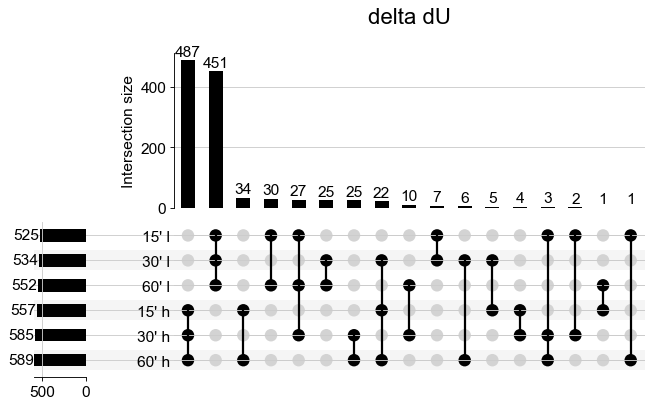

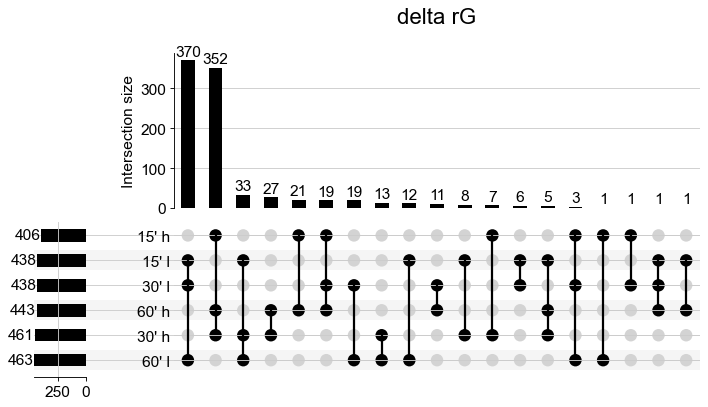

In [31]:
contents_rG, contents_dU = run_upset(fc_thr = 0.05, pv_thr = 0.05,draw=True)

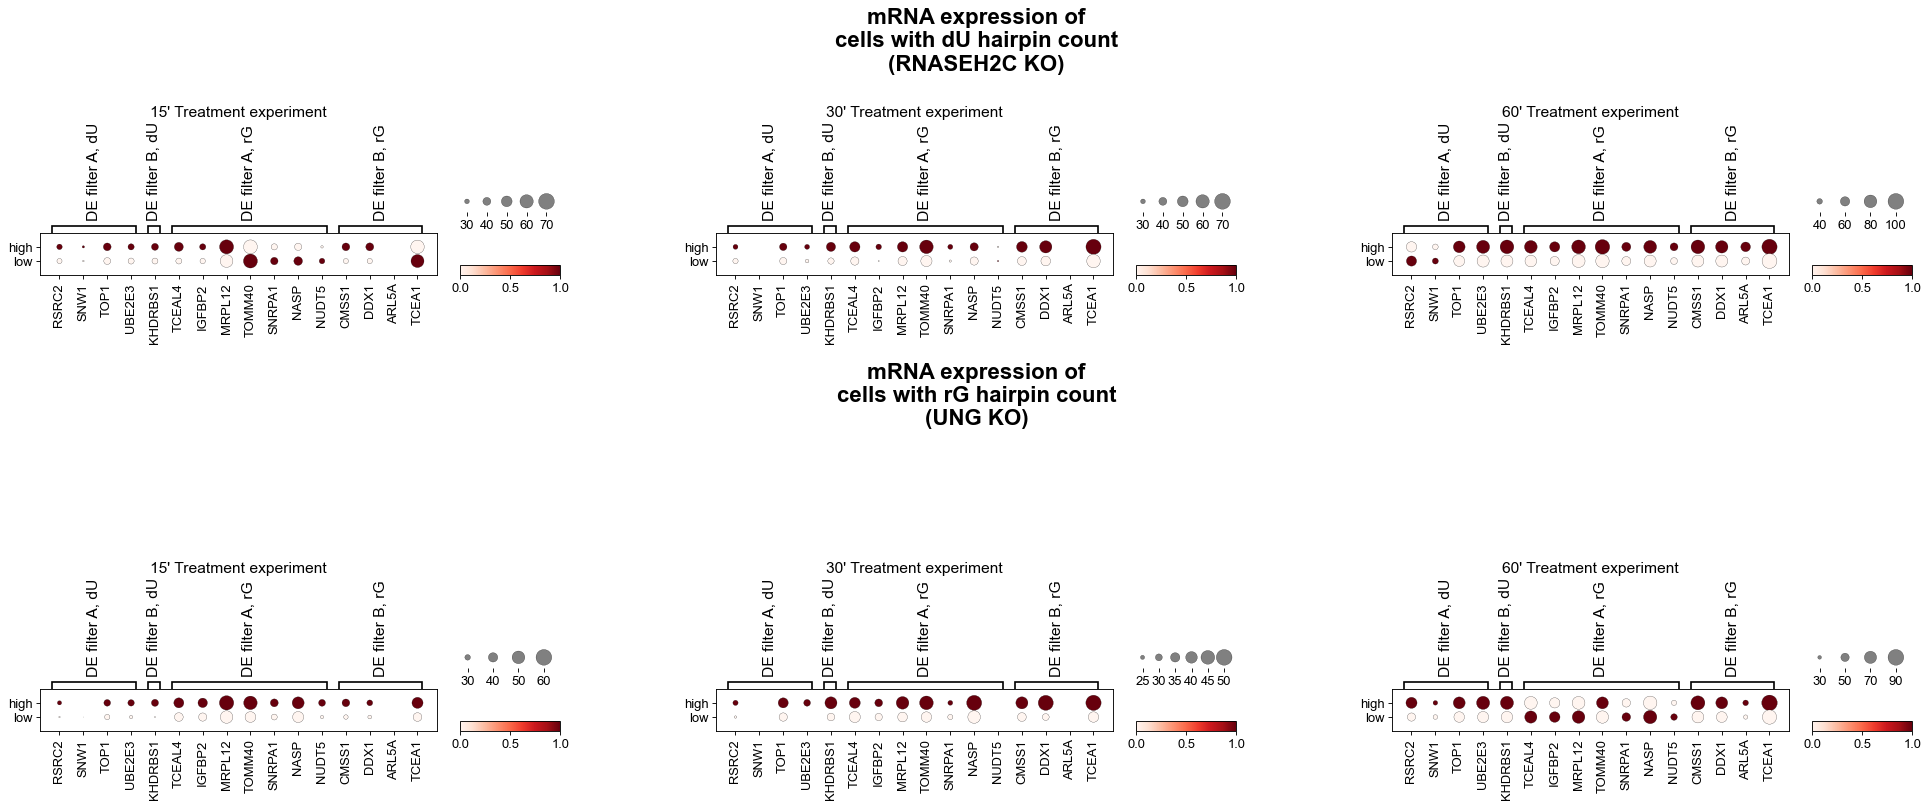

In [32]:
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(30,10), gridspec_kw={'hspace':2,'wspace':0.3})

times = ['15','30','60'] 
damages = ['dU','rG'] 
repairs = ['Uracil-repair', 'riboG-repair']

for i,adata in enumerate([mix15,mix30,mix60]):
        
    signal = list()
    
    genes_dict = {}
    for j in range(2):
        
        cnts = eval(f'contents_{damages[j]}')
        de1 = set(cnts['15\' l']).intersection(set(cnts['60\' h']))
        de2 = set(cnts['15\' h']).intersection(set(cnts['60\' l']))

        genes_dict.update({
            f'DE filter A, {damages[j]}': list(de1),
            f'DE filter B, {damages[j]}' : list(de2)
        })
        
    for j in range(2):
        ax_dict = sc.pl.dotplot(
            adata[adata.obs[repairs[j]] != 'none',],
            genes_dict,title=f'{times[i]}\' Treatment experiment',
            dot_min=0.2, 
            standard_scale='var',
            groupby=repairs[j],
            colorbar_title = None,
            size_title = None,

            show=False,ax=axes[j,i]
        )
    
grid = plt.GridSpec(rows, cols)
create_subtitle(fig, grid[0, ::], 'mRNA expression of\ncells with dU hairpin count\n(RNASEH2C KO)\n')
create_subtitle(fig, grid[1, ::], 'mRNA expression of\ncells with rG hairpin count\n(UNG KO)')
    
fig.set_facecolor('w')
fig.savefig('network-analysis/dotplot-DE.pdf')
plt.show()

In [ ]:
# dU @15'
'TCEA1', 'TOMM40'
# dU @60'
'SNW1', 'RSRC2'

# rG @60'
'TCEAL4','MRPL12','IGFBP2'

# dU @15' && rG @60'
'SNRPA1', 'NASP','NUDT5'

__Conclusions__:

There some genes that shows the alteration of gene expression overtime.  
- [SNRPA1](#SNRPA1)

___
## Task: Find differentially expressed genes in PPI network of KO genes 
Here, I'm using `DESeq2` results to find genes with high log2FC from PPI networks within our datasets. Theses are hypothetically genes with context specific biological signals. I started with list of genes from PPI network of KO genes. Then, I filtered them by significant differential expression comparing high at 60' vs. high at 15' for two phenotypes of study. 

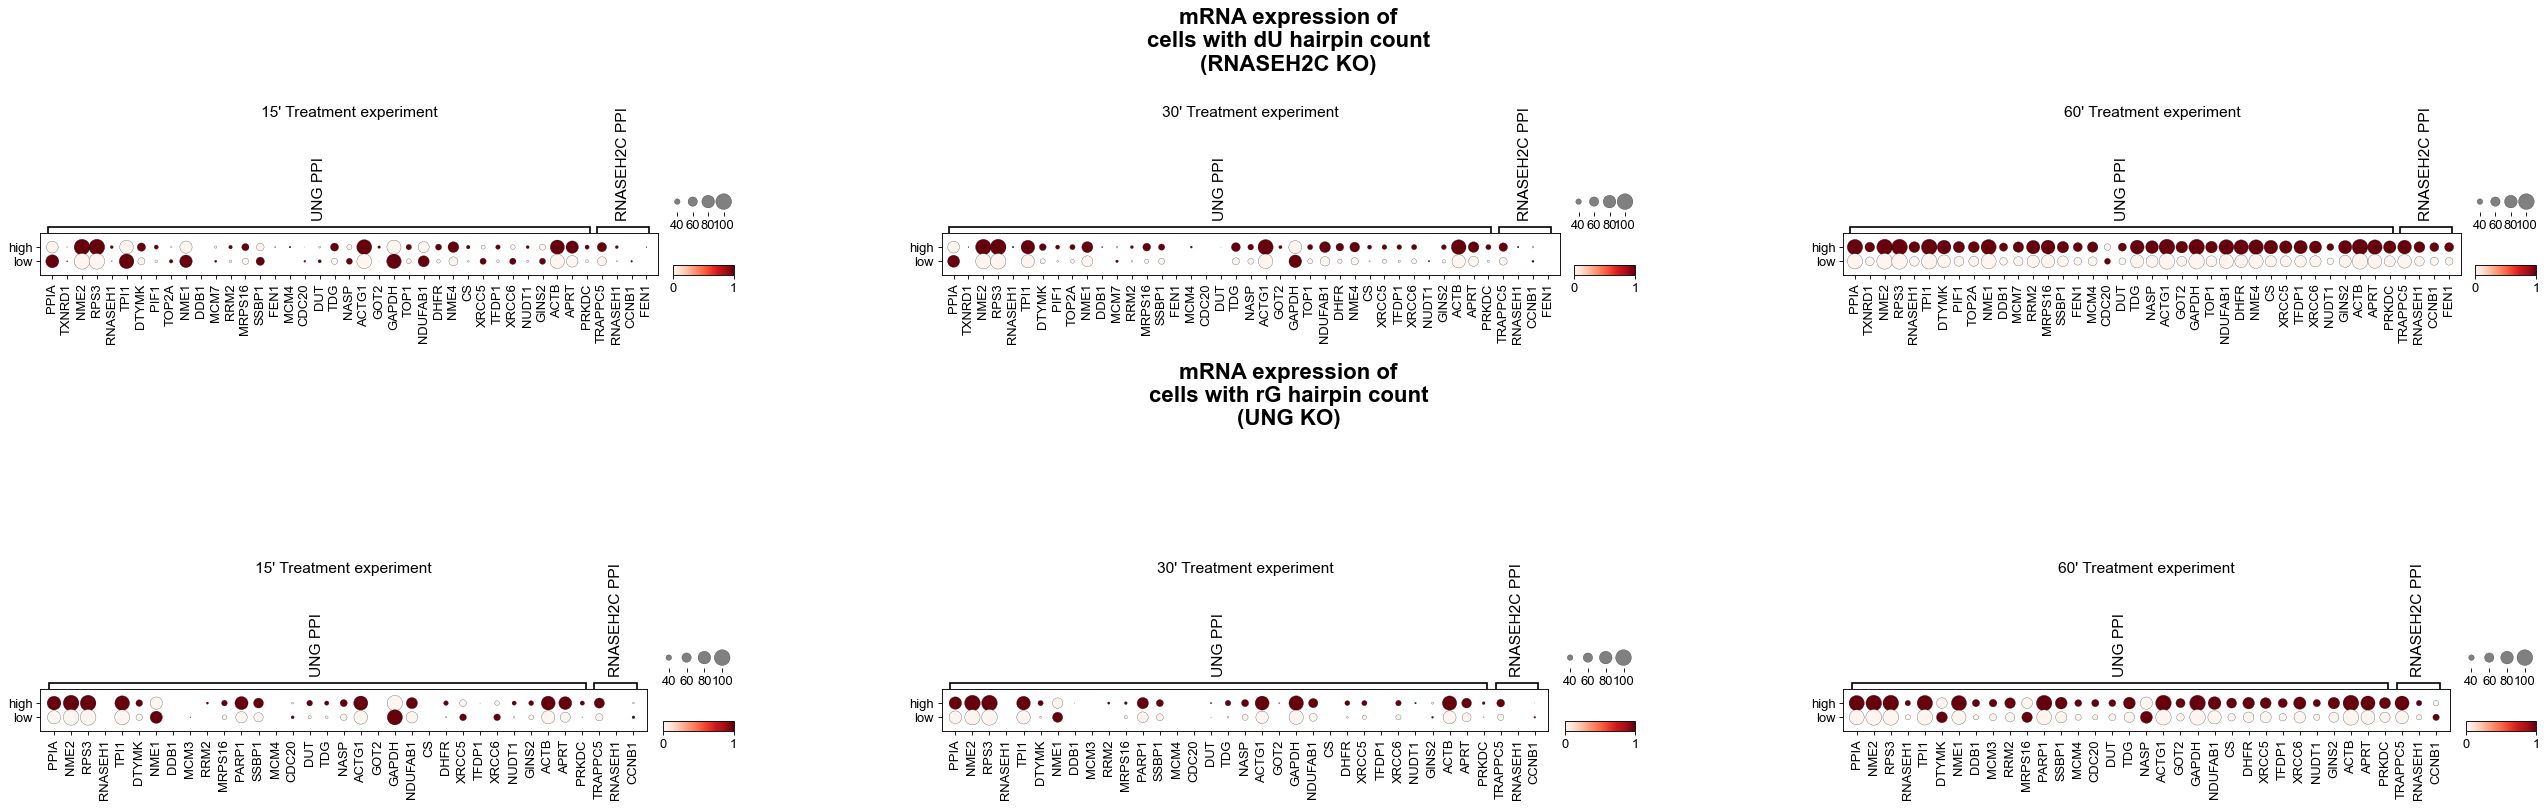

In [34]:
fc_thr = 0
pv_thr = 0.05

contents_rG, contents_dU = run_upset(fc_thr, pv_thr)
          
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(40,10), gridspec_kw={'hspace':2,'wspace':0.3})

times = ['15','30','60'] 
damages = ['dU','rG'] 
repairs = ['Uracil-repair', 'riboG-repair']

for i,adata in enumerate([mix15,mix30,mix60]):
    
    ung = set(adata.var_names).intersection(set(UNG_graph.vs["name"]))
    rnase = set(adata.var_names).intersection(set(RNASEH2C_graph.vs["name"]))
    
    signal = list()
    
    for j in range(2):
        
        de = set(deseq[f'delta_{damages[j]}_60_vs_15'][
            (abs(deseq[f'delta_{damages[j]}_60_vs_15'].log2FoldChange) > fc_thr) &
            (deseq[f'delta_{damages[j]}_60_vs_15'].pvalue < pv_thr)
            
        ].index)

        cnts = eval(f'contents_{damages[j]}')
#         de1 = set(cnts['15\' l']).intersection(set(cnts['60\' h']))
        de1 = set(cnts['60\' h'])
#         de2 = set(cnts['15\' h']).intersection(set(cnts['60\' l']))
        de2 = set(cnts['60\' l'])

        genes = set(ung).intersection(rnase).intersection(de).intersection(de1).intersection(de2)
        
        ppi_genes_dict = {
            'UNG PPI': list(set(ung).intersection(de or de1 or de2)),
            'RNASEH2C PPI': list(set(rnase).intersection(de or de1 or de2))
        }

        ax_dict = sc.pl.dotplot(
            adata[adata.obs[repairs[j]] != 'none',],
            ppi_genes_dict,title=f'{times[i]}\' Treatment experiment',
            dot_min=0.2, 
            standard_scale='var',
            colorbar_title = None,
            size_title = None,
#             swap_axes=True,
            groupby=repairs[j],
            show=False,ax=axes[j,i]
        )
    
grid = plt.GridSpec(rows, cols)
create_subtitle(fig, grid[0, ::], 'mRNA expression of\ncells with dU hairpin count\n(RNASEH2C KO)\n')
create_subtitle(fig, grid[1, ::], 'mRNA expression of\ncells with rG hairpin count\n(UNG KO)')
    
fig.set_facecolor('w')
fig.savefig('network-analysis/dotplot-DE-PPI.pdf')
plt.show()

In [35]:
# dU, UNG PPI
'TPI1', 'NDUFAB1', 'PPIA', 'GINS2','SSBP1'

# dU, RNASEH2C PPI
'CCNB1'

# rG, UNG PPI
'MCM3','MCM4'


# dU & rG, UNG PPI
'NME1', 'XRCC6', 'GAPDH', 'XRCC5'

('NME1', 'XRCC6', 'GAPDH', 'XRCC5')

__Conclusions:__

An instance result, [_CCNB1_ gene](#CCNB1) is cell cycle related gene which is underrepresented in cells with high phenotypes in all conditions but it's overrepresented in cells with high Uracil repair phenotype at 60'. Therefore, cells treated with hairpins that mimic Uracil damage cuase this experssion dynamic over time.

___
## Task: Find genes alter expression from DNA Damage and Repair pathways 


In [ ]:
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(45,18), gridspec_kw={'hspace':1,'wspace':0.3})

times = ['15','30','60'] 
damages = ['dU','rG'] 
repairs = ['Uracil-repair', 'riboG-repair']

for i,adata in enumerate([mix15,mix30,mix60]):
    
    signal = list()
    
    for j in range(2):        
        
        genes_dict = DDR_core_pathways
        
        for k in genes_dict: 
            if k in [
                'Nucleotide Excision Repair (NER, including TC-NER and GC-NER))', 
                'Homologous Recomination (HR)'
            ]:
                del genes_dict[k]
            genes_dict[k] = [gene for gene in genes_dict[k] if gene not in ['MRE11A', 'SHFM1', 'SLX1A', 'TREX1'] ]
        
        ax_dict = sc.pl.dotplot(
            adata[adata.obs[repairs[j]] != 'none',],
            genes_dict,title=f'{times[i]}\' Treatment experiment\n\n',
#             dot_min=0.2, 
            standard_scale='var',
            colorbar_title = None,
            size_title = None,
#             swap_axes=True,
            groupby=repairs[j],
            show=False,ax=axes[j,i]
        )
    
grid = plt.GridSpec(rows, cols)
create_subtitle(fig, grid[0, ::], 'mRNA expression of\ncells with dU hairpin count\n(RNASEH2C KO)\n\n')
create_subtitle(fig, grid[1, ::], 'mRNA expression of\ncells with rG hairpin count\n(UNG KO)')
    
fig.set_facecolor('w')
# fig.savefig('network-analysis/DE-PPI-dotplot.pdf')
plt.show()

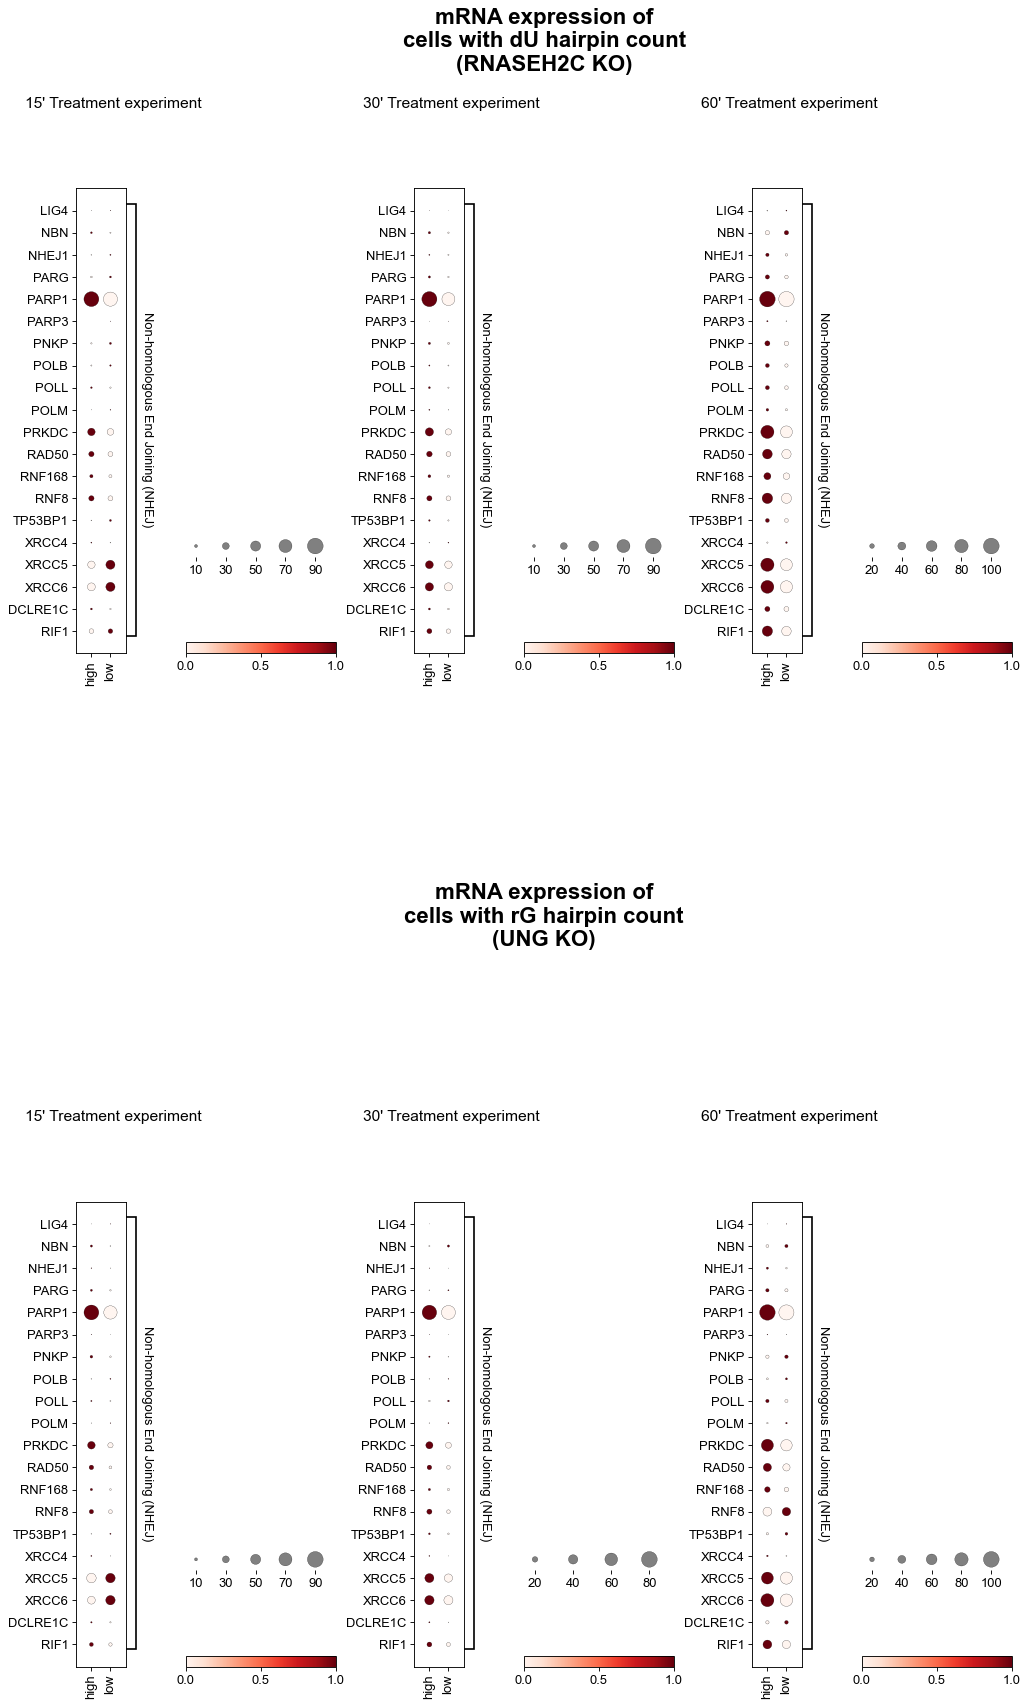

In [38]:
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15,25), gridspec_kw={'hspace':1,'wspace':0.3})

times = ['15','30','60'] 
damages = ['dU','rG'] 
repairs = ['Uracil-repair', 'riboG-repair']

for i,adata in enumerate([mix15,mix30,mix60]):
    
    signal = list()
    
    for j in range(2):        
        
        genes_dict = DDR_pathways
        
        for k in genes_dict: 
            genes_dict[k] = [gene for gene in genes_dict[k] if gene not in ['DNTT', 'FAM175A','MRE11A']]
            
        ax_dict = sc.pl.dotplot(
            adata[adata.obs[repairs[j]] != 'none',],
            {'Non-homologous End Joining (NHEJ)': 
             genes_dict['Non-homologous End Joining (NHEJ)']},
            title=f'{times[i]}\' Treatment experiment\n\n',
#             dot_min=0.2, 
            standard_scale='var',
            colorbar_title = None,
            size_title = None,
            swap_axes=True,
            groupby=repairs[j],
            show=False,ax=axes[j,i]
        )
    
grid = plt.GridSpec(rows, cols)
create_subtitle(fig, grid[0, ::], 'mRNA expression of\ncells with dU hairpin count\n(RNASEH2C KO)\n\n')
create_subtitle(fig, grid[1, ::], 'mRNA expression of\ncells with rG hairpin count\n(UNG KO)')
    
fig.set_facecolor('w')
fig.savefig('network-analysis/dotplot-DDR-NHEJ.pdf')
plt.show()

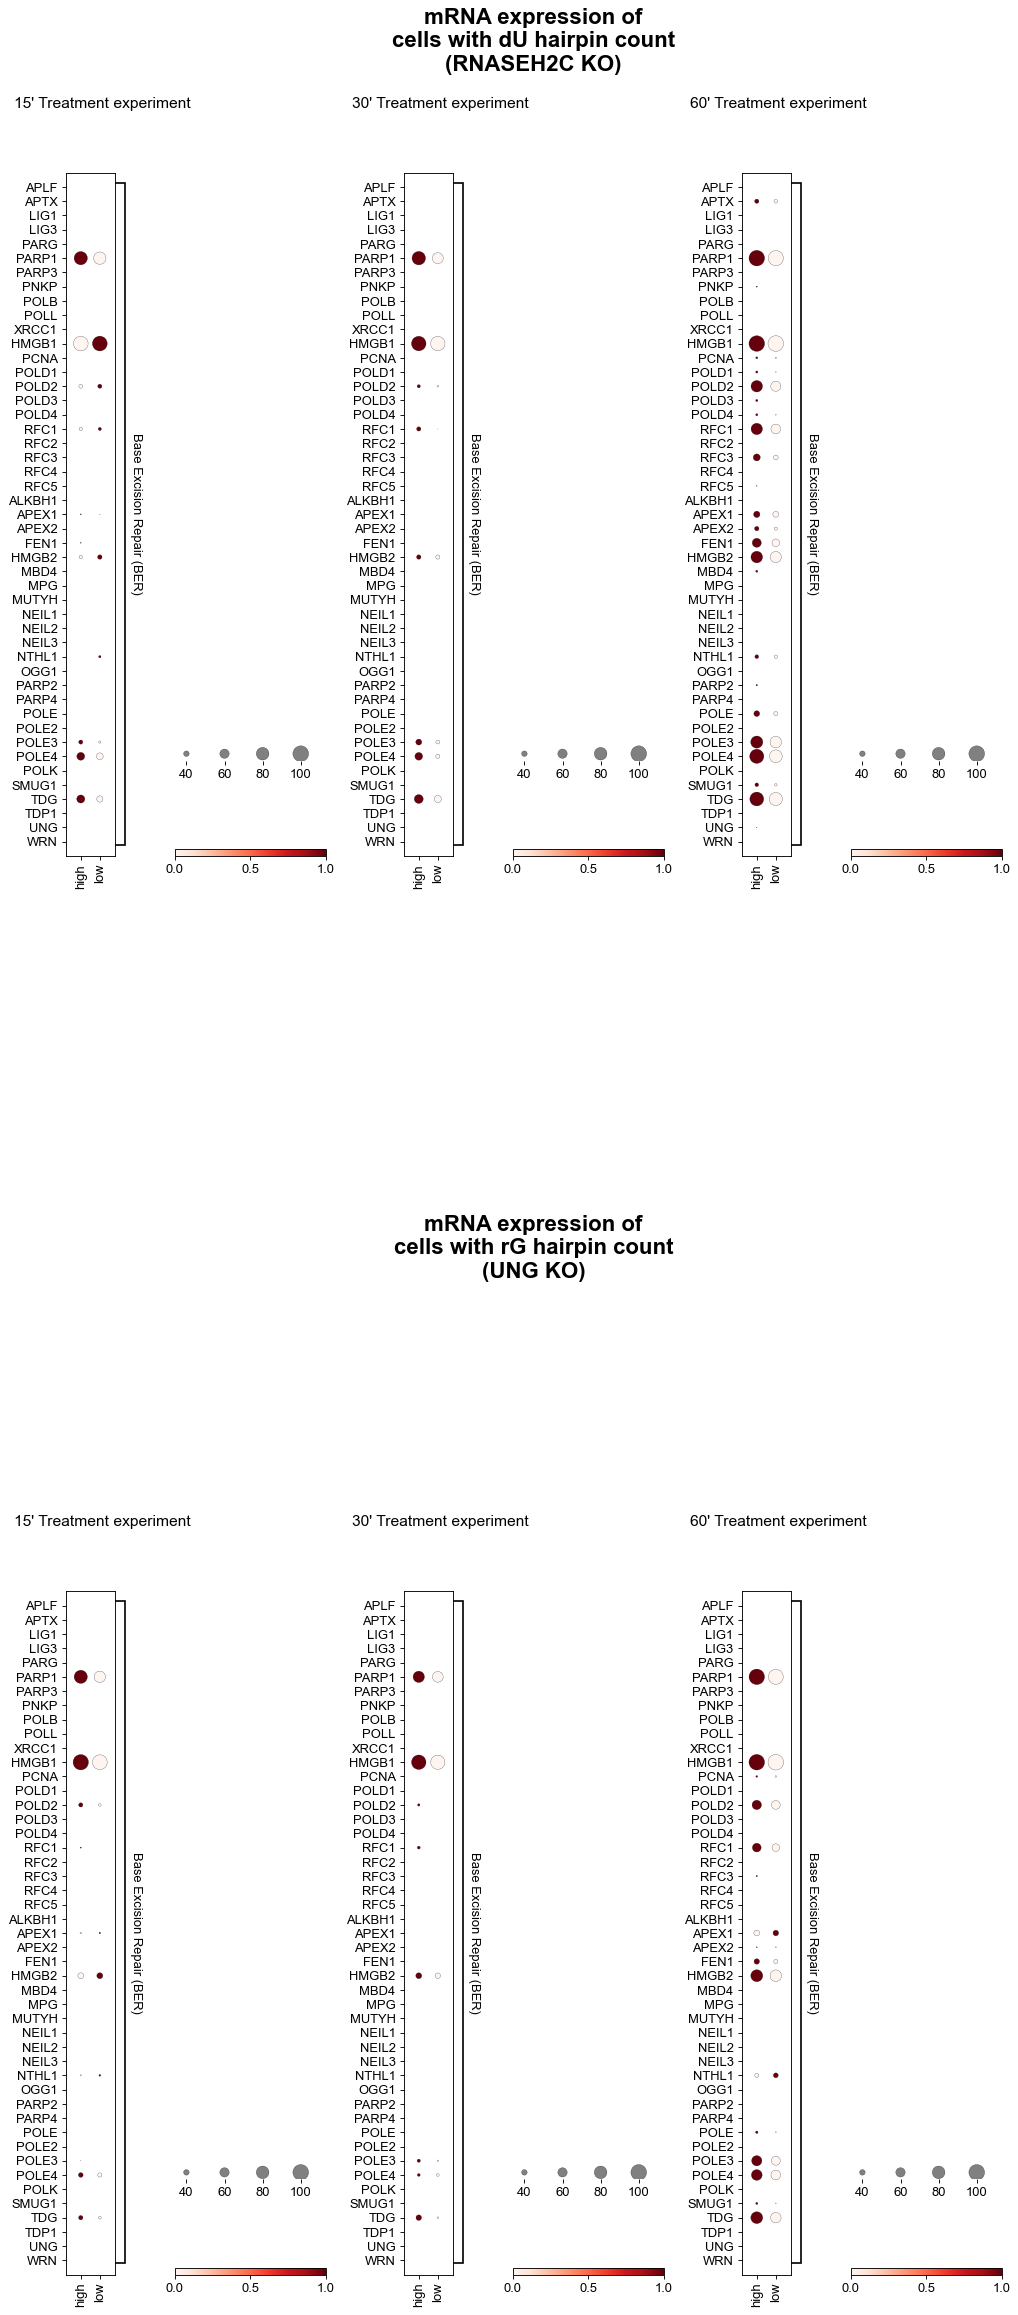

In [39]:
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15,35), gridspec_kw={'hspace':1,'wspace':0.3})

times = ['15','30','60'] 
damages = ['dU','rG'] 
repairs = ['Uracil-repair', 'riboG-repair']

for i,adata in enumerate([mix15,mix30,mix60]):
    
    signal = list()
    
    for j in range(2):        
        
        genes_dict = DDR_pathways
        
        for k in genes_dict: 
            genes_dict[k] = [gene for gene in genes_dict[k] if gene not in ['DNTT', 'FAM175A']]
            
        ax_dict = sc.pl.dotplot(
            adata[adata.obs[repairs[j]] != 'none',],
            {'Base Excision Repair (BER)': 
             genes_dict['Base Excision Repair (BER)']},
            title=f'{times[i]}\' Treatment experiment\n\n',
            dot_min=0.2, 
            standard_scale='var',
            colorbar_title = None,
            size_title = None,
            swap_axes=True,
            groupby=repairs[j],
            show=False,ax=axes[j,i]
        )
    
grid = plt.GridSpec(rows, cols)
create_subtitle(fig, grid[0, ::], 'mRNA expression of\ncells with dU hairpin count\n(RNASEH2C KO)\n\n')
create_subtitle(fig, grid[1, ::], 'mRNA expression of\ncells with rG hairpin count\n(UNG KO)')
    
fig.set_facecolor('w')
fig.savefig('network-analysis/dotplot-DDR-BER.pdf')
plt.show()

In [40]:
# rG & dU, Non-homologous End Joining (NHEJ)
'XRCC5','XRCC6'

# rG, Non-homologous End Joining (NHEJ)
'RNF8'
# dU, Base Excision Repair (BER)
'HMGB1'

'HMGB1'

___
## Task: Enriched pathways ...

Load iPAGE results:

In [41]:
rG15 = ipd.make_ipage_run_data_frame('deseq/delta_rG_15/')
rG30 = ipd.make_ipage_run_data_frame('deseq/delta_rG_30/')
rG60 = ipd.make_ipage_run_data_frame('deseq/delta_rG_60/')

rG60vs15 = ipd.make_ipage_run_data_frame('deseq/delta_rG_60_vs_15/')

dU15 = ipd.make_ipage_run_data_frame('deseq/delta_dU_15/')
dU30 = ipd.make_ipage_run_data_frame('deseq/delta_dU_30/')
dU60 = ipd.make_ipage_run_data_frame('deseq/delta_dU_60/')

dU60vs15 = ipd.make_ipage_run_data_frame('deseq/delta_dU_60_vs_15/')

Load relative annotations:

In [42]:
ann = ipd.make_annotation_dict([
    rG15,rG30,rG60,rG60vs15,
    dU15,dU30,dU60,dU60vs15,
])

In [43]:
# ann['REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION']['genes']

Find enriched genesets with at least one gene from PPI network of KO genes:

In [44]:
def check_gene(ann,genes):
    membs = {}
    for gs in ann:
        membs[gs]= []
        for gene in genes:
            if gene in ann[gs]['genes']:
                membs[gs].append(gene)
#         if membs[gs]: 
#             print (f'{gs}\n\t{membs[gs]}')
    return membs

In [45]:
RNASEH2C_ppi_gs = check_gene(ann,RNASEH2C_graph.vs["name"])

In [46]:
UNG_ppi_gs = check_gene(ann,UNG_graph.vs["name"])

___
___
# GENES

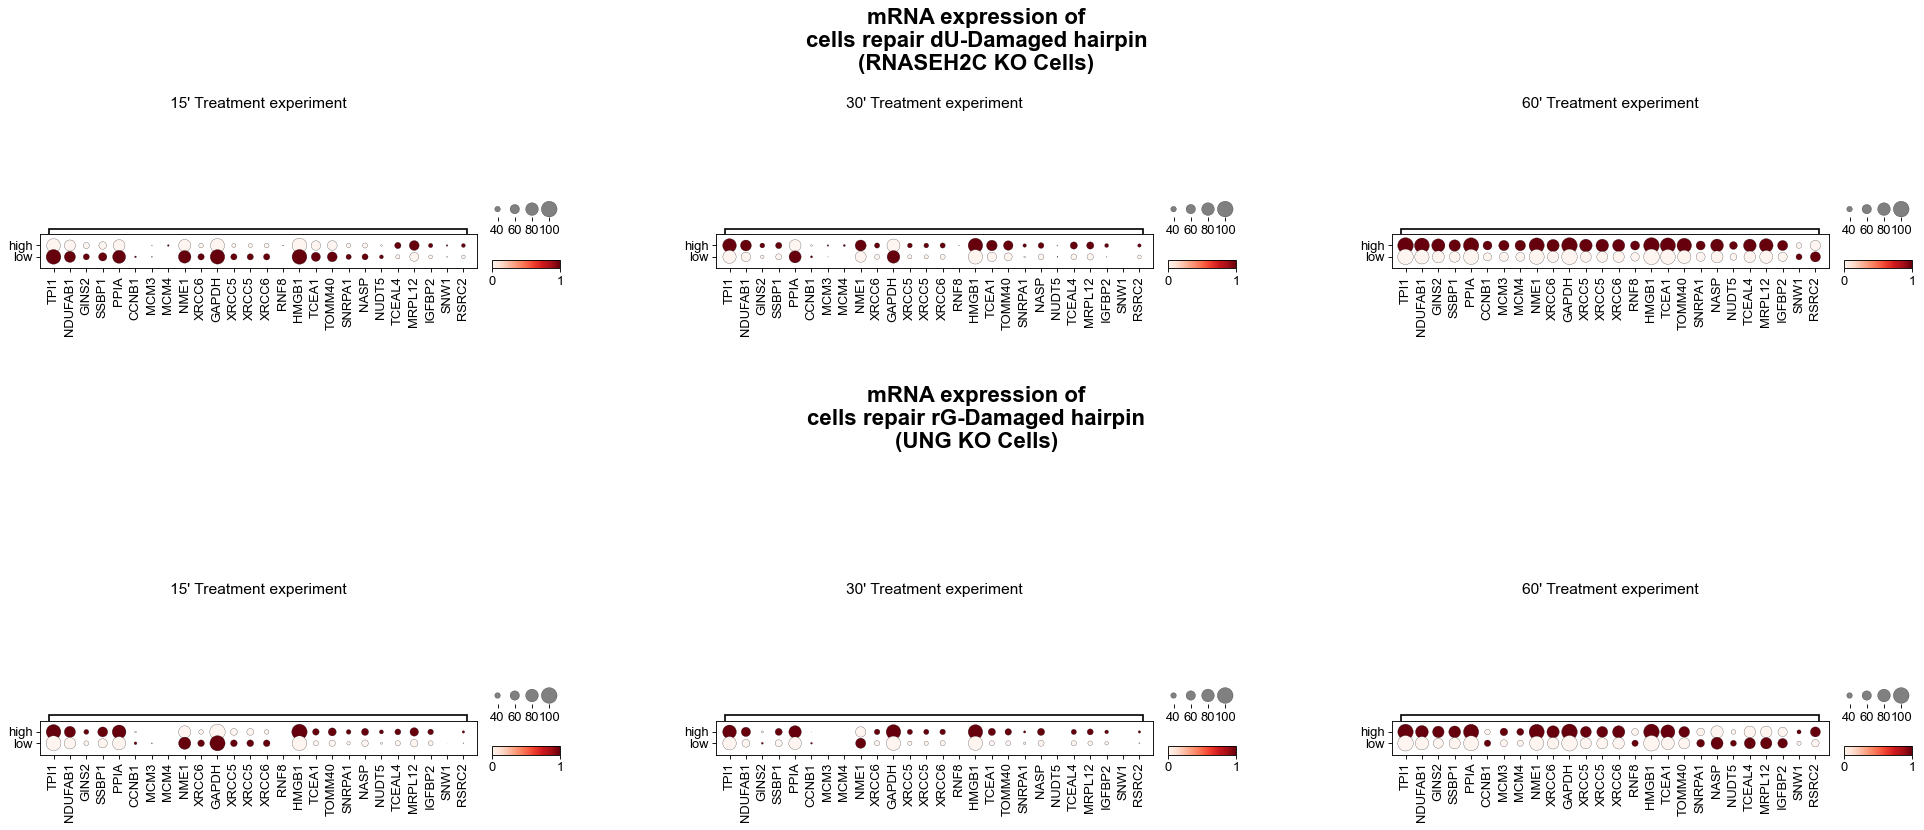

In [48]:
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(30,10), gridspec_kw={'hspace':3,'wspace':0.3})

times = ['15','30','60'] 
damages = ['dU','rG'] 
repairs = ['Uracil-repair', 'riboG-repair']

for i,adata in enumerate([mix15,mix30,mix60]):
    
    signal = list()
    
    for j in range(2):        
        
        genes_dict = {'':[
            # dU, UNG PPI
            'TPI1', 'NDUFAB1', 'GINS2','SSBP1','PPIA',
            # dU, RNASEH2C PPI
            'CCNB1',
            # rG, UNG PPI
            'MCM3','MCM4',
            # dU & rG, UNG PPI
            'NME1', 'XRCC6', 'GAPDH', 'XRCC5',

            # rG & dU, Non-homologous End Joining (NHEJ)
            'XRCC5','XRCC6',
            # rG, Non-homologous End Joining (NHEJ)
            'RNF8',
            # dU, Base Excision Repair (BER)
            'HMGB1',
            # dU @15'
            'TCEA1', 'TOMM40',
            # dU @15' && rG @60'
            'SNRPA1', 'NASP','NUDT5',
            # rG @60'
            'TCEAL4','MRPL12','IGFBP2',
            # dU @60'
            'SNW1', 'RSRC2',
        ]}
        
        ax_dict = sc.pl.dotplot(
            adata[adata.obs[repairs[j]] != 'none',],
            genes_dict,
            title=f'{times[i]}\' Treatment experiment\n\n',
            dot_min=0.2, 
            standard_scale='var',
            colorbar_title = None,
            size_title = None,
#             swap_axes=True,
            groupby=repairs[j],
            show=False,ax=axes[j,i]
        )
    
grid = plt.GridSpec(rows, cols)
create_subtitle(fig, grid[0, ::], 'mRNA expression of\ncells repair dU-Damaged hairpin\n(RNASEH2C KO Cells)\n\n')
create_subtitle(fig, grid[1, ::], 'mRNA expression of\ncells repair rG-Damaged hairpin\n(UNG KO Cells)')
    
fig.set_facecolor('w')
fig.savefig('network-analysis/dotplot-prefinal.pdf')
plt.show()